# IOTA + microgrid tests

In [1]:
from iota import ProposedTransaction, Address, Tag, TryteString, Iota, Transaction
from iota.crypto.types import Seed
import json
import pandapower as pp
import numpy as np
from numpy.random import rand
import pandas as pd
import os
import pprint

### General parameters

In [2]:
demand_file_path = os.path.join('data', 'demand.csv')
price_file_path = os.path.join('data', 'price.csv')
supply_file_path = os.path.join('data', 'supply.csv')

### IOTA seed creation

In [3]:
demand = pd.read_csv(demand_file_path, index_col=0, header=None)
supply = pd.read_csv(supply_file_path, index_col=0, header=None)
price = pd.read_csv(price_file_path, index_col=0, header=None)
num_agents = demand.shape[0]
num_household = demand.shape[0]
steps = demand.shape[1]

In [4]:
supply
a_series = (supply != 0).any(axis=1)
new_df = supply.loc[a_series]

In [5]:
gen_nodes = np.array(new_df.index)

In [6]:
my_seed = Seed.random()
api = Iota('https://nodes.devnet.iota.org:443')
total_addresses = steps * (2 * num_agents + 1)
addresses = api.get_new_addresses(count=total_addresses)['addresses']

### Address generation

In [7]:
price_addresses_splits = []
money_addresses_splits = []
addresses1 = addresses[30:]
addresses2 = addresses[:30]
for agent in range(0, num_agents):
    price_addresses_splits.append(addresses1[agent*steps:agent*steps+steps])
    money_addresses_splits.append(addresses2[agent*steps:agent*steps+steps])
publish_addresses = addresses1[-steps:]

In [8]:
# Agent class definition

class Agent:
    def __init__(self, demand, supply, node, publish_address, price_address, money_address, price):
        """ Initialize agent instance.
        
        Args: 
            demand (list): list of floats with demand data
            supply (list): list of floats with supply. Ceros if no supply.
            node (float): number of the node.
            publish_address (list): list of iota.types.Address with the publish address.
            price_address (list): list of node's price addresses.
            money_address (list): list of node's money addresses.
            price (list): list of prices for supply offers.
        """
        self.demand = demand
        self.supply = supply
        self.node = node
        self.publish_address = publish_address
        self.price_address = price_address
        self.money_address = money_address
        self.consumption = demand-supply
        self.price = price
    
    def publish_info(self, data, address):
        """ Send transaction with data to specified address
        
        Args:
            data (dict): information to be sent.
            address (iota.types.Address): Destination address for information
        """
        # Build TX object
        tx = ProposedTransaction(
            address = Address(address),
            message = TryteString.from_unicode(json.dumps(data)),
            tag = Tag('INFO'),
            value = 0)
        # Send information
        tx = api.prepare_transfer(transfers=[tx])
        result = api.send_trytes(tx['trytes'], depth=3, min_weight_magnitude=9)
        return result
    
    def pay_power(self, step):
        """ Send power payment
        
        Args:
            step (float): step running at the moment.
        """
        unpack_data = self.check_address(step, 'price')
        for index, node in enumerate(unpack_data[0]['node']):
            data_to_send = {'payment': unpack_data[0]['price']*unpack_data[0]['power'][index]}
            address = self.address_dict[node]['money_address'][step]
            self.publish_info(data_to_send, address)
        
    def publish_energy_info(self, step):
        """ Build and send energy information
        
        Args:
            step (float): Step running at the moment.
        """
        data = {'node': self.node,
                'demand': self.demand[step],
                'supply': self.supply[step],
                'consumption': self.consumption[step],
                'price': self.price[step]}
        address = self.publish_address[step]
        self.publish_info(data, address)
        return data
    
    def check_address(self, step, address_type):
        """ Recover information from address.
        
        Args:
            step (float): Step running at the moment.
            address_type (str): Vector code to look for the address
        """
        
        if address_type == 'price':
            address = self.price_address[step]
        elif address_type == 'money':
            address = self.money_address[step]
        
        transactions = api.find_transactions(addresses=[address,])

        hashes = []
        for txhash in transactions['hashes']:
            hashes.append(txhash)

        trytes = api.get_trytes(hashes)['trytes']

        parts = []
        for trytestring in trytes:
            tx = Transaction.from_tryte_string(trytestring)
            parts.append((tx.current_index, tx.signature_message_fragment))

        parts.sort(key=lambda x: x[0])

        full_message = TryteString.from_unicode('')

        retrieved_data = []
        for index, part in parts:
            retrieved_data.append(json.loads(part.decode(errors='ignore')))
        return retrieved_data
    
    def get_demand(self):
        # Visualize demand
        return self.demand
    
    def get_supply(self):
        # Visualize supply
        return self.supply
    
    def get_node(self):
        # Visualize node
        return self.node
    
    def get_price_address(self):
        # Visualize price address
        return self.price_address
    
    def get_money_address(self):
        # Visualize money address
        return self.money_address
    
    def get_consumption(self):
        # Visualize consumption
        return self.consumption
    
    def get_prices(self):
        # Visualize price
        return self.price
    
    def assign_address_dict(self, address_dict):
        """ Assign address dict to node
        
        Args:
            address_dict (dict): With known addresses for each node (price and money) and publish addresses
        """
        self.address_dict = address_dict

### Agent creation

In [9]:
demand = pd.read_csv(demand_file_path, header=None, index_col=0)
supply = pd.read_csv(supply_file_path, header=None, index_col=0)
price = pd.read_csv(price_file_path, header=None, index_col=0)
num_agents = demand.shape[0]
num_household = demand.shape[0]
steps = demand.shape[1]

In [10]:
agents = []
for index in range(0, num_agents):
    agents.append(Agent(np.array(demand.iloc[index]), 
                       np.array(supply.iloc[index]), 
                       index, publish_addresses, 
                       price_addresses_splits[index], 
                       money_addresses_splits[index], 
                       np.array(price.iloc[index])))

In [11]:
def build_address_dictionary(agents, publish_addresses):
    agent_addresses = {}
    agent_addresses['publish_address'] = publish_addresses
    for index, agent in enumerate(agents):
        agent_addresses[index] = {'price_address': agent.get_price_address(),
                                  'money_address': agent.get_money_address()}
    return agent_addresses

In [12]:
def check_published_data(address):
    transactions = api.find_transactions(addresses=[address,])

    hashes = []
    for txhash in transactions['hashes']:
        hashes.append(txhash)
        
    trytes = api.get_trytes(hashes)['trytes']

    parts = []
    for trytestring in trytes:
        tx = Transaction.from_tryte_string(trytestring)
        parts.append((tx.current_index, tx.signature_message_fragment))

    parts.sort(key=lambda x: x[0])

    full_message = TryteString.from_unicode('')

    node_data = []
    for index, part in parts:
#         pprint.pprint(json.loads(part.decode(errors='ignore')))8.299+8.299+8.299+8.154
        node_data.append(json.loads(part.decode(errors='ignore')))

    return node_data

In [13]:
def single_sided_auction(node_data):
    node_vec = []
    supply_vec = []
    supply_price = []
    demand = []
    ED = 0
    for node in node_data:
        node_vec.append(node['node'])
        supply_vec.append(node['supply'])
        supply_price.append(node['price'])
        demand.append(node['demand'])
        ED += node['demand']
    supply_df = pd.DataFrame(data = {'Agents': node_vec, 'Supply': supply_vec, 'Price': supply_price, 'Demand': demand})
    supply_df = supply_df.sort_values(by='Price')
    cum_supply = np.cumsum(supply_df['Supply'])
    supply_df['Cumsum'] = cum_supply
    for index, value in enumerate(supply_df.Cumsum):
        if value >= ED:
            break
    return supply_df, ED, supply_df.iloc[index]['Price']

In [14]:
addresses_dict = build_address_dictionary(agents, publish_addresses)
for agent in agents:
    agent.assign_address_dict(addresses_dict)

### Microgrid creation

In [15]:
def micro_grid_exec(step):
    net = pp.create_empty_network()
    min_pu = 0.95
    max_pu = 1.05

    bus = []
    for index in range(len(agents)):
        bus.append(pp.create_bus(net, vn_kv=110, min_vm_pu=min_pu, max_vm_pu=max_pu))

    # bus0 = pp.create_bus(net, vn_kv=110, min_vm_pu=min_pu, max_vm_pu=max_pu)
    # bus1 = pp.create_bus(net, vn_kv=110, min_vm_pu=min_pu, max_vm_pu=max_pu)
    # bus2 = pp.create_bus(net, vn_kv=110, min_vm_pu=min_pu, max_vm_pu=max_pu)
    # bus3 = pp.create_bus(net, vn_kv=110, min_vm_pu=min_pu, max_vm_pu=max_pu)
    # bus4 = pp.create_bus(net, vn_kv=110, min_vm_pu=min_pu, max_vm_pu=max_pu)
    # bus5 = pp.create_bus(net, vn_kv=110, min_vm_pu=min_pu, max_vm_pu=max_pu)

    lines = []
    for index in range(len(agents)):
        if index < len(agents) - 1:
            lines.append(pp.create_line(net, bus[index], bus[index+1], length_km=1, std_type='149-AL1/24-ST1A 110.0'))
        else:
            lines.append(pp.create_line(net, bus[index], bus[0], length_km=1, std_type='149-AL1/24-ST1A 110.0'))

    # line1 = pp.create_line(net, bus0, bus1, length_km=1, std_type='149-AL1/24-ST1A 110.0')
    # line2 = pp.create_line(net, bus1, bus2, length_km=1, std_type='149-AL1/24-ST1A 110.0')
    # line3 = pp.create_line(net, bus2, bus3, length_km=1, std_type='149-AL1/24-ST1A 110.0')
    # line4 = pp.create_line(net, bus3, bus4, length_km=1, std_type='149-AL1/24-ST1A 110.0')
    # line5 = pp.create_line(net, bus4, bus5, length_km=1, std_type='149-AL1/24-ST1A 110.0')
    # line6 = pp.create_line(net, bus5, bus0, length_km=1, std_type='149-AL1/24-ST1A 110.0')

    for index in range(len(agents)):
        pp.create_load(net, bus[index], p_mw=supply_df['Demand'][index])

    # pp.create_load(net, bus0, p_mw=supply_df['Demand'][0])
    # pp.create_load(net, bus1, p_mw=supply_df['Demand'][1])
    # pp.create_load(net, bus2, p_mw=supply_df['Demand'][2])
    # pp.create_load(net, bus3, p_mw=supply_df['Demand'][3])
    # pp.create_load(net, bus4, p_mw=supply_df['Demand'][4])
    # pp.create_load(net, bus5, p_mw=supply_df['Demand'][5])

    gens = []
    for index in range(len(agents)):
        if supply.iloc[index][step + 1] != 0:
            print(index)
            pp.create_gen(net, bus[index], p_mw=np.array(supply[step + 1])[index], min_p_mw=0, max_p_mw=np.array(supply[step + 1])[index], controllable=True, slack=True)
            
    pp.runpp(net)
    pf_result = net.res_gen
    
    return pf_result

In [16]:
nodes = [0,1,2,3,4,5]

In [17]:
def payment_setup(step):
    power_per_agent = []
    for agent in agents:
        agent.get_node()
        demand = agent.demand[0]
        try:
            supply = gen_dict[agent.get_node()]
        except:
            supply = agent.get_supply()[0]
        to_app = supply - demand
        if abs(to_app) < 0.00001:
            to_app = 0
        power_per_agent.append(to_app)
    to_earn = {}
    to_pay = {}
    for index, payment in enumerate(power_per_agent):
        if payment < 0:
            to_pay[index] = abs(payment)
        else:
            to_earn[index] = payment
    
    payment_info = {}
    for payer, balance in to_pay.items():
        payment_info[payer] = {'node': [], 'total': []}
        for earner, gain in to_earn.items():
            if gain > 0:
                if balance >= gain:
                    payment_info[payer]['node'].append(earner)
                    payment_info[payer]['total'].append(gain)
                    to_pay[payer] = to_pay[payer] - gain
                    to_earn[earner] = to_earn[earner] - gain
                elif balance < gain:
                    payment_info[payer]['node'].append(earner)
                    payment_info[payer]['total'].append(balance)
                    to_pay[payer] = to_pay[payer] - balance
                    to_earn[earner] = to_earn[earner] - balance
                    break
    gather_data = {}
    for index, agent in enumerate(agents):
        info_dict = {}
        info_dict['price'] = price
        try:
            info_dict['node'] = payment_info[index]['node']
            info_dict['power'] = payment_info[index]['total']
        except:
            pass
        gather_data[index] = info_dict
    print(power_per_agent)
    for index, agent in enumerate(agents):
        address = addresses_dict[index]['price_address'][step]
        data = gather_data[index]
        tx = ProposedTransaction(address=Address(address), message=TryteString.from_unicode(json.dumps(data)), tag=Tag('PRICE'),value=0)

        tx = api.prepare_transfer(transfers=[tx])

        result = api.send_trytes(tx['trytes'], depth=3, min_weight_magnitude=9)
    pay_nodes = set(nodes) - set(gen_nodes)
    for node in pay_nodes:
        agents[node].pay_power(step)

In [18]:
for step in range(steps):
    for index, agent in enumerate(agents):
        agent.publish_energy_info(step)
    node_data = check_published_data(publish_addresses[step])
    supply_df, ED, price = single_sided_auction(node_data)
    pf_result = micro_grid_exec(step)
    supply_df.set_index('Agents', inplace=True)
    gen_values = pf_result['p_mw']
    gen_dict = dict(zip(gen_nodes, gen_values))
    print(pf_result)
    total_demand = sum(supply_df['Demand'])
    total_supply = sum(gen_dict.values())
    losses = total_supply - total_demand
    payment_setup(step)
#     print(supply_df)
#     print(price)

0
3
4
5
        p_mw    q_mvar  va_degree  vm_pu
0  11.172836 -0.065455        0.0    1.0
1  10.639151 -0.065494        0.0    1.0
2   5.416000 -0.033262        0.0    1.0
3   5.957000 -0.033262        0.0    1.0
[6.001835956732363, -5.416, -5.957000000000001, 5.090150950426207, -0.36299999999999955, 0.6449999999999969]
0
3
4
5
        p_mw    q_mvar  va_degree  vm_pu
0  12.581649 -0.065145        0.0    1.0
1  12.781632 -0.065181        0.0    1.0
2   6.634000 -0.033262        0.0    1.0
3   6.059000 -0.033262        0.0    1.0
[7.410649137997054, -5.416, -5.957000000000001, 7.23263194069764, 0.8550000000000004, 0.7470000000000008]
0
3
4
5
        p_mw    q_mvar  va_degree  vm_pu
0  16.829091 -0.064209        0.0    1.0
1  16.804081 -0.064229        0.0    1.0
2   8.125000 -0.033262        0.0    1.0
3   8.463000 -0.033262        0.0    1.0
[11.658090990240815, -5.416, -5.957000000000001, 11.255081353663947, 2.346, 3.1510000000000007]
0
3
4
5
        p_mw    q_mvar  va_degree  vm_pu
0

In [19]:
step = 0
for agent in agents:
    print(agent.check_address(step, 'price'))

[{'price': 1.2}]
[{'price': 1.2, 'node': [0], 'power': [5.416]}]
[{'price': 1.2, 'node': [0, 3, 5], 'power': [0.585835956732363, 5.090150950426207, 0.6449999999999969]}]
[{'price': 1.2}]
[{'price': 1.2, 'node': [], 'power': []}]
[{'price': 1.2}]


In [20]:
step = 0
print(agents[0].check_address(step, 'money'))
print(agents[3].check_address(step, 'money'))

[{'payment': 6.4992}, {'payment': 0.7030031480788356}]
[{'payment': 6.108181140511448}]


In [21]:
gen_dict

{0: 8.940373954504889, 3: 9.008366510788838, 4: 4.041, 5: 4.338000000000001}

<BarContainer object of 4 artists>

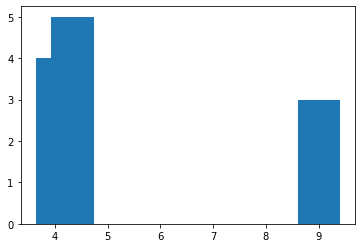

In [27]:
import matplotlib.pyplot as plt
plt.bar(gen_dict.values(), gen_dict.keys())